In [1]:
import sqlite3, string
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from imblearn.pipeline import Pipeline
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con = sqlite3.connect('prods.db')
products = pd.read_sql("SELECT * FROM products", con)

products.drop_duplicates(inplace=True)
products.dropna(inplace=True)

products['category_name'] = products['category_name'].str.lower()

products.head()

id         shop  product_id  \
0   1  perekrestok       32392   
1   2  perekrestok       10299   
2   3  perekrestok      404062   
3   4  perekrestok       34160   
4   5  perekrestok       32227   

                                                name  \
0                        Голубика Маркет Fresh, 125г   
1           Горошек зелёный Маркет Перекрёсток, 400г   
2  Колбаса Докторская варёная категории А в натур...   
3                                         Клементины   
4                                             Бананы   

                                                code           category_name  \
0                         golubika-market-fresh-125g  готовимся к праздникам   
1            gorosek-zelenyj-market-perekrestok-400g  готовимся к праздникам   
2  kolbasa-doktorskaa-varenaa-kategorii-a-v-natur...  готовимся к праздникам   
3                                         klementiny  готовимся к праздникам   
4                                             banany  готовимся к праздникам   

            category_code   price  
0  gotovimsa-k-prazdnikam  239.99  
1  gotovimsa-k-prazdnikam   93.99  
2  gotovimsa-k-prazdnikam  779.99  
3  gotovimsa-k-prazdnikam  229.99  
4  gotovimsa-k-prazdnikam  119.99

In [3]:
products.drop(columns=['id', 'product_id', 'code', 'category_code'], inplace=True)
products.head()

shop                                               name  \
0  perekrestok                        Голубика Маркет Fresh, 125г   
1  perekrestok           Горошек зелёный Маркет Перекрёсток, 400г   
2  perekrestok  Колбаса Докторская варёная категории А в натур...   
3  perekrestok                                         Клементины   
4  perekrestok                                             Бананы   

            category_name   price  
0  готовимся к праздникам  239.99  
1  готовимся к праздникам   93.99  
2  готовимся к праздникам  779.99  
3  готовимся к праздникам  229.99  
4  готовимся к праздникам  119.99

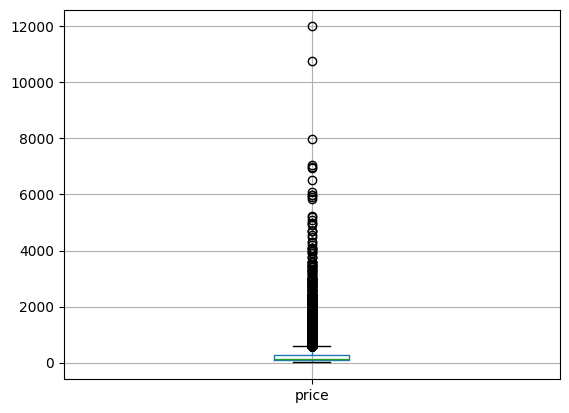

In [4]:
products.boxplot(column=['price'])
plt.show()

In [5]:
products.sort_values(by='price', ascending=False).head(15)

shop                                               name  \
6136        ashan  Бренди Torres, Jaime I Испания, 0,7 л + 2 Стакана   
7751        ashan            Коньяк «Коктебель» 25 лет Россия, 0,7 л   
7679        ashan  Коньяк Lheraud Vieux Millenaire в подарочной у...   
7690        ashan             Коньяк Remy Martin VSOP Франция, 0,7 л   
7673        ashan  Коньяк Hine Rare в подарочной упаковке Франция...   
7648        ashan  Коньяк ARARAT Двин в подарочной упаковке Армен...   
6079        ashan              Аперитив Aperol Aperitivo Италия, 3 л   
7647        ashan            Коньяк ARARAT Васпуракан Армения, 0,7 л   
423   perekrestok                               Икра нерки зернистая   
7656        ashan  Коньяк Camus V. S. O. P в подарочной упаковке ...   
7649        ashan  Коньяк ARARAT Наири в подарочной упаковке Арме...   
7395        ashan  Джин The London №1 Original Blue Великобритани...   
7652        ashan  Коньяк Bache Gabrielsen American Oak Франция, ...   
8591        ashan  Ром That Boutique-Y Rum Company Signature Blen...   
7654        ashan  Коньяк Bache Gabrielsen VSOP ординарный Франци...   

               category_name     price  
6136    алкоголь (самовывоз)  11999.95  
7751    алкоголь (самовывоз)  10768.99  
7679    алкоголь (самовывоз)   7999.00  
7690    алкоголь (самовывоз)   7067.99  
7673    алкоголь (самовывоз)   6999.00  
7648    алкоголь (самовывоз)   6947.99  
6079    алкоголь (самовывоз)   6499.95  
7647    алкоголь (самовывоз)   6092.99  
423   готовимся к праздникам   5999.00  
7656    алкоголь (самовывоз)   5998.99  
7649    алкоголь (самовывоз)   5915.99  
7395    алкоголь (самовывоз)   5844.99  
7652    алкоголь (самовывоз)   5247.99  
8591    алкоголь (самовывоз)   5207.99  
7654    алкоголь (самовывоз)   5099.00

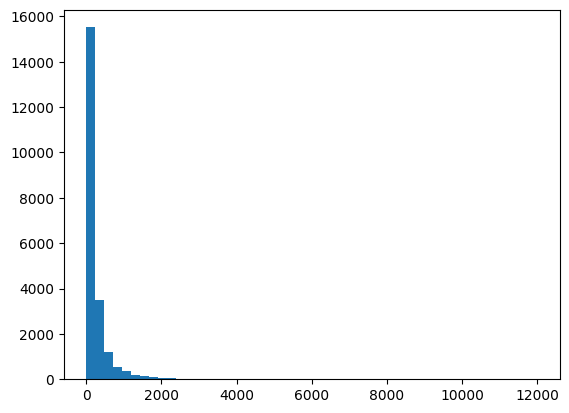

In [6]:
data = products['price']
plt.hist(data, bins=50)
plt.show()

In [7]:
products['price'].describe()

count    21769.000000
mean       261.487882
std        412.358708
min          1.590000
25%         74.990000
50%        139.900000
75%        279.000000
max      11999.950000
Name: price, dtype: float64

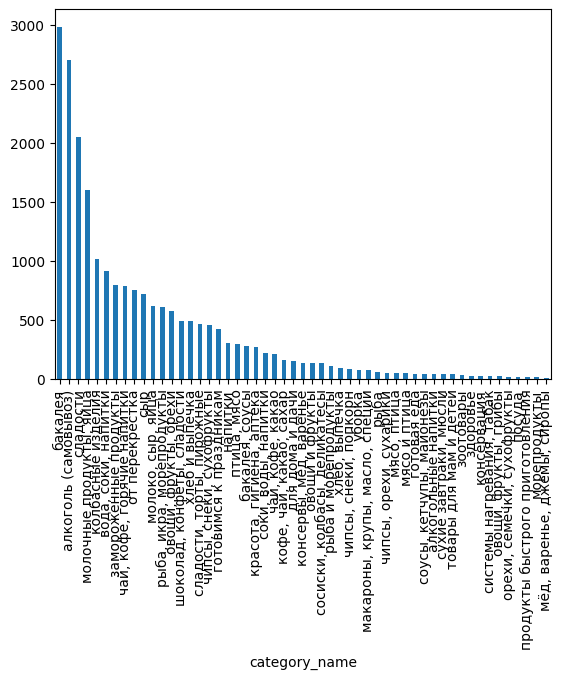

In [8]:
products['category_name'].value_counts().plot.bar()
plt.show()

In [9]:
products.category_name = products.category_name.astype('category')
products.dtypes

shop               object
name               object
category_name    category
price             float64
dtype: object

In [10]:
category_mapping = products.groupby('category_name')['shop'].unique().to_dict()
for category1, category2 in category_mapping.items():
    print(category1, ":", category2)

алкоголь (самовывоз) : ['ashan']
алкогольные напитки : ['perekrestok']
бакалея : ['ashan']
бакалея, соусы : ['magnit']
вода, соки, напитки : ['ashan']
готовая еда : ['perekrestok']
готовимся к праздникам : ['perekrestok']
для дома и дачи : ['perekrestok']
замороженные продукты : ['perekrestok' 'magnit' 'ashan']
здоровье : ['perekrestok']
зоотовары : ['perekrestok']
колбасные изделия : ['perekrestok' 'ashan']
консервация : ['perekrestok']
консервы, мёд, варенье : ['magnit']
кофе, чай, какао, сахар : ['perekrestok']
красота, гигиена, аптека : ['perekrestok']
макароны, крупы, масло, специи : ['perekrestok']
молоко, сыр, яйца : ['perekrestok' 'magnit']
молочные продукты, яйца : ['ashan']
морепродукты : ['perekrestok']
мясо и птица : ['perekrestok']
мясо, птица : ['magnit']
мёд, варенье, джемы, сиропы : ['perekrestok']
напитки : ['magnit']
овощи и фрукты : ['magnit']
овощи, фрукты, грибы : ['perekrestok']
овощи, фрукты, орехи : ['ashan']
орехи, семечки, сухофрукты : ['perekrestok']
от перек

C:\Users\shany\AppData\Local\Temp\ipykernel_6988\1497464240.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_mapping = products.groupby('category_name')['shop'].unique().to_dict()


In [11]:
products['category_name'].cat.categories

Index(['алкоголь (самовывоз)', 'алкогольные напитки', 'бакалея',
       'бакалея, соусы', 'вода, соки, напитки', 'готовая еда',
       'готовимся к праздникам', 'для дома и дачи', 'замороженные продукты',
       'здоровье', 'зоотовары', 'колбасные изделия', 'консервация',
       'консервы, мёд, варенье', 'кофе, чай, какао, сахар',
       'красота, гигиена, аптека', 'макароны, крупы, масло, специи',
       'молоко, сыр, яйца', 'молочные продукты, яйца', 'морепродукты',
       'мясо и птица', 'мясо, птица', 'мёд, варенье, джемы, сиропы', 'напитки',
       'овощи и фрукты', 'овощи, фрукты, грибы', 'овощи, фрукты, орехи',
       'орехи, семечки, сухофрукты', 'от перекрёстка', 'посуда',
       'продукты быстрого приготовления', 'птица, мясо', 'рыба',
       'рыба и морепродукты', 'рыба, икра, морепродукты',
       'системы нагревания, табак', 'сладости', 'сладости, торты, пирожные',
       'соки, воды, напитки', 'сосиски, колбасы, деликатесы',
       'соусы, кетчупы, майонезы', 'сухие завтр

In [12]:
#добавим столбец, который будет Y
def general_category(arr):
    ctg = {'Молочные продукты': ['молоко, сыр, яйца', 'молочные продукты, яйца', 'сыр'],
        'Мясные продукты': ['мясо и птица', 'мясо, птица', 'птица, мясо', 'сосиски, колбасы, деликатесы', 'колбасные изделия'],
        'Рыба и морепродукты': ['морепродукты', 'рыба и морепродукты', 'рыба, икра, морепродукты', 'рыба'],
        'Овощи, фрукты, закуски': ['овощи и фрукты', 'овощи, фрукты, грибы', 'овощи, фрукты, орехи', 'орехи, семечки, сухофрукты'],
        'Бакалея и соусы': ['бакалея', 'бакалея, соусы', 'консервация', 'консервы, мёд, варенье', 'макароны, крупы, масло, специи','мёд, варенье, джемы, сиропы', 'соусы, кетчупы, майонезы', 'сухие завтраки, мюсли', 'чипсы, орехи, сухарики', 'чипсы, снеки, попкорн','чипсы, снеки, сухофрукты'],
        'Сладости': ['сладости', 'сладости, торты, пирожные', 'шоколад, конфеты, сладости'],
        'Выпечка и хлеб': ['хлеб и выпечка', 'хлеб, выпечка'],
        'Чай, кофе, какао, сахар': ['кофе, чай, какао, сахар', 'чай, кофе, горячие напитки', 'чай, кофе, какао'],
        'Напитки': ['алкоголь (самовывоз)', 'алкогольные напитки', 'вода, соки, напитки', 'соки, воды, напитки', 'напитки'],
        'Замороженные продукты': ['замороженные продукты'],
        'Прочее': ['готовая еда', 'готовимся к праздникам', 'для дома и дачи', 'здоровье', 'зоотовары', 'красота, гигиена, аптека', 'от перекрёстка', 'посуда', 'продукты быстрого приготовления', 'системы нагревания, табак', 'товары для мам и детей', 'уборка']}

    for key, array in ctg.items():
        for element in arr:
            if element in array:
                return key

products['general_category'] = products.apply(general_category, axis=1)
products.general_category = products.general_category.astype('category')
products.sample(20)

shop                                               name  \
13949        ashan            Филе трески BigFish замороженное, 600 г   
8623         ashan   Сидр «Абрау-Дюрсо» игристый сухой Россия, 0,75 л   
6724         ashan  Вино Vaziani Старый Метехи домашнее белое полу...   
7095         ashan               Водка Mamont с кружкой Россия, 0,7 л   
7535         ashan  Игристое вино Sandiliano розовое полусладкое И...   
507    perekrestok  Вермишель быстрого приготовления с куриным бул...   
284    perekrestok           Чай Ahmad ассорти Радость Рождества, 71г   
3925        magnit                    Грибы Шампиньоны Для гриля 700г   
7906         ashan           Ликер Vedrenne Triple Sec Франция, 0,7 л   
11780        ashan  Колбаса вареная «Идель» Оригинальная с говядин...   
5312        magnit          Чай зеленый Greenfield Flying Dragon 100г   
20760        ashan    Чай черный «Шах» Gold Индийский листовой, 25 шт   
20278        ashan                     Чай зеленый Ahmad Tea, 100x2 г   
10617        ashan  Сыр мягкий Schonfeld Blue с благородной голубо...   
19393        ashan  Смесь для выпечки «С.Пудовъ» Имбирное печенье,...   
5131        magnit                       Джем Махеевъ Клубничный 300г   
444    perekrestok              Губка для обуви бесцветная Пр!ст, 25г   
16819        ashan                  Зефир «Лянеж» бело-розовый, 315 г   
18315        ashan        Макаронные изделия Agnesi Le Lasagne, 500 г   
2052   perekrestok  Десерт Blanc ванильно-шоколадный замороженный,...   

                    category_name    price         general_category  
13949       замороженные продукты   400.99    Замороженные продукты  
8623         алкоголь (самовывоз)   249.95                  Напитки  
6724         алкоголь (самовывоз)   575.99                  Напитки  
7095         алкоголь (самовывоз)  1799.00                  Напитки  
7535         алкоголь (самовывоз)   749.99                  Напитки  
507                от перекрёстка    17.99                   Прочее  
284        готовимся к праздникам   499.99                   Прочее  
3925               овощи и фрукты   189.99   Овощи, фрукты, закуски  
7906         алкоголь (самовывоз)  1917.99                  Напитки  
11780           колбасные изделия   368.99          Мясные продукты  
5312             чай, кофе, какао   199.99  Чай, кофе, какао, сахар  
20760  чай, кофе, горячие напитки    83.99  Чай, кофе, какао, сахар  
20278  чай, кофе, горячие напитки   379.00  Чай, кофе, какао, сахар  
10617                         сыр   286.99        Молочные продукты  
19393                     бакалея    92.99          Бакалея и соусы  
5131       консервы, мёд, варенье   139.99          Бакалея и соусы  
444                от перекрёстка    27.99                   Прочее  
16819                    сладости   130.99                 Сладости  
18315                     бакалея   368.99          Бакалея и соусы  
2052   шоколад, конфеты, сладости   149.99                 Сладости

In [13]:
#все ли категории учтены
nan_in_df = products.isnull().sum().sum()
print('Number of NaN values present: ' + str(nan_in_df))

result = products[products['general_category'].isnull()]
print(result)

Number of NaN values present: 0
Empty DataFrame
Columns: [shop, name, category_name, price, general_category]
Index: []


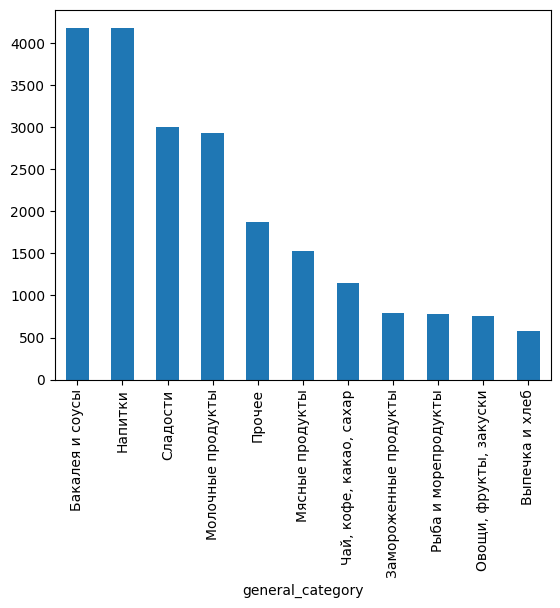

In [14]:
products['general_category'].value_counts().plot.bar()
plt.show()

In [28]:
import re, nltk

def create_dict(df_column, name_dict):
    unique_words = []
    lemmatize = nltk.WordNetLemmatizer()
    for name in df_column:
        name = re.sub(r"\b\d+(г|шт)\b","", name)
        name = re.sub("[^а-яА-я+ё]"," ", name)
        for i in name:
            lemmatize.lemmatize(i)    
        words = name.split()

        for word in words:
            word = lemmatize.lemmatize(word)
            if not word.isdigit() and word.lower() not in unique_words and len(word)>=3:
                unique_words.append(word.lower())

    with open(f"{name_dict}.txt", "w", encoding='utf8') as output:
        [output.write(str(i) + ' ') for i in unique_words]
        #output.write(str(unique_words))

    return unique_words

create_dict(products.category_name, 'category_dict')


['готовимся',
 'праздникам',
 'перекрёстка',
 'готовая',
 'еда',
 'молоко',
 'сыр',
 'яйца',
 'овощи',
 'фрукты',
 'грибы',
 'макароны',
 'крупы',
 'масло',
 'специи',
 'чипсы',
 'снеки',
 'попкорн',
 'шоколад',
 'конфеты',
 'сладости',
 'соки',
 'воды',
 'напитки',
 'хлеб',
 'выпечка',
 'мясо',
 'птица',
 'колбасные',
 'изделия',
 'рыба',
 'замороженные',
 'продукты',
 'морепродукты',
 'товары',
 'для',
 'мам',
 'детей',
 'соусы',
 'кетчупы',
 'майонезы',
 'кофе',
 'чай',
 'какао',
 'сахар',
 'сухие',
 'завтраки',
 'мюсли',
 'быстрого',
 'приготовления',
 'консервация',
 'здоровье',
 'орехи',
 'семечки',
 'сухофрукты',
 'мёд',
 'варенье',
 'джемы',
 'сиропы',
 'зоотовары',
 'красота',
 'гигиена',
 'аптека',
 'уборка',
 'посуда',
 'дома',
 'дачи',
 'алкогольные',
 'системы',
 'нагревания',
 'табак',
 'бакалея',
 'сосиски',
 'колбасы',
 'деликатесы',
 'торты',
 'пирожные',
 'консервы',
 'сухарики',
 'алкоголь',
 'самовывоз',
 'молочные',
 'икра',
 'горячие',
 'вода']

In [16]:
with open('category_dict.txt', 'r') as dictionary:
    words_for_vec = dictionary.read().split()
print(words_for_vec)
print(len(words_for_vec))

['готовимся', 'праздникам', 'перекрёстка', 'готовая', 'еда', 'молоко', 'сыр', 'яйца', 'овощи', 'фрукты', 'грибы', 'макароны', 'крупы', 'масло', 'специи', 'чипсы', 'снеки', 'попкорн', 'шоколад', 'конфеты', 'сладости', 'соки', 'воды', 'напитки', 'хлеб', 'выпечка', 'мясо', 'птица', 'колбасные', 'изделия', 'рыба', 'замороженные', 'продукты', 'морепродукты', 'товары', 'для', 'мам', 'детей', 'соусы', 'кетчупы', 'майонезы', 'кофе', 'чай', 'какао', 'сахар', 'сухие', 'завтраки', 'мюсли', 'быстрого', 'приготовления', 'консервация', 'здоровье', 'орехи', 'семечки', 'сухофрукты', 'мёд', 'варенье', 'джемы', 'сиропы', 'зоотовары', 'красота', 'гигиена', 'аптека', 'уборка', 'посуда', 'дома', 'дачи', 'алкогольные', 'системы', 'нагревания', 'табак', 'бакалея', 'сосиски', 'колбасы', 'деликатесы', 'торты', 'пирожные', 'консервы', 'сухарики', 'алкоголь', 'самовывоз', 'молочные', 'икра', 'горячие', 'вода']
85


In [17]:
# приведение категорий из магазинов в понятную форму
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')

def transform_text(df_column):
    new_text = []
    lemmatize = nltk.WordNetLemmatizer()
    for i in df_column:
        text = re.sub(r"\b\d+(г|шт)\b", "", i)
        text = re.sub("[^а-яА-я+ё]"," ", i) #удаляем неалфавитные символы
        text = nltk.word_tokenize(text) #токенизация
        text = [lemmatize.lemmatize(word) for word in i] #лемматизация
        text = "".join(text)
        new_text.append(text)

    count = CountVectorizer(vocabulary = words_for_vec) 
    matrix = count.fit_transform(new_text).toarray() #векторизация
    return matrix

vectors_store_categories = transform_text(products.category_name)
for i in vectors_store_categories:
    print(i)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shany\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shany\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [18]:
from sklearn.model_selection import train_test_split

X = vectors_store_categories
y = products['general_category']
#y = our_categories

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(14585, 85) (7184, 85) (14585,) (7184,)


In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC #метод опорных векторов
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

NB_model = GaussianNB()
SVC_model = SVC()
KNN_model = KNeighborsClassifier(n_neighbors=5)

NB_model.fit(x_train, y_train)
SVC_model.fit(x_train, y_train)
KNN_model.fit(x_train, y_train)

NB_prediction = NB_model.predict(x_test)
SVC_prediction = SVC_model.predict(x_test)
KNN_prediction = KNN_model.predict(x_test)

print(accuracy_score(NB_prediction, y_test))
print(accuracy_score(SVC_prediction, y_test))
print(accuracy_score(KNN_prediction, y_test))

print(classification_report(NB_prediction, y_test))
print(classification_report(SVC_prediction, y_test))
print(classification_report(KNN_prediction, y_test))

1.0
1.0
1.0
                         precision    recall  f1-score   support

        Бакалея и соусы       1.00      1.00      1.00      1375
         Выпечка и хлеб       1.00      1.00      1.00       195
  Замороженные продукты       1.00      1.00      1.00       245
      Молочные продукты       1.00      1.00      1.00       965
        Мясные продукты       1.00      1.00      1.00       480
                Напитки       1.00      1.00      1.00      1438
 Овощи, фрукты, закуски       1.00      1.00      1.00       267
                 Прочее       1.00      1.00      1.00       599
    Рыба и морепродукты       1.00      1.00      1.00       253
               Сладости       1.00      1.00      1.00       975
Чай, кофе, какао, сахар       1.00      1.00      1.00       392

               accuracy                           1.00      7184
              macro avg       1.00      1.00      1.00      7184
           weighted avg       1.00      1.00      1.00      7184

          

In [20]:
joblib.dump(SVC_model, 'model_category.pkl')

['model_category.pkl']

In [21]:
prod_db = sqlite3.connect('prods.db')
df = pd.read_sql("SELECT * FROM products", prod_db)

df.sample(5)

id    shop  product_id  \
16332  16333   ashan    17855614   
15266  15267   ashan    19951677   
20100  20101   ashan    15963453   
17841  17842   ashan     1871117   
5939    5940  magnit  1000229306   

                                                    name  \
16332       Шоколад «Бабаевский» темный с фундуком, 90 г   
15266  Открытка шоколадная мини Chokocat Дракон Счаст...   
20100      Кофе молотый Ambassador Platinum Crema, 200 г   
17841  Каша овсяная Myllyn Paras БИО-БИО с овсяными о...   
5939            Борщ с курицей Главсуп замороженный 250г   

                                                    code  \
16332                     shokolad-babaevskiy-funduk-90g   
15266                 otk-mini-schast-nov-goda-drakon-5g   
20100                 kofe-molotyy-crema-200g-ambassador   
17841  kasha-ovsyanaya-myllyn-paras-bio-bio-s-ovsyany...   
5939        borshch-s-kuritsey-glavsup-zamorozhenny-250g   

                    category_name           category_code   price  
16332                    Сладости   konditerskie_izdeliya  153.99  
15266                    Сладости   konditerskie_izdeliya   26.90  
20100  Чай, кофе, горячие напитки      chay-kofe-sladosti  199.95  
17841                     Бакалея                bakaleya   21.99  
5939        Замороженные продукты  zamorozhennye-produkty  124.99

In [22]:
with open('model_category.pkl', 'rb') as f:
    calassifer = joblib.load(f)

category_vec = transform_text(df.category_name)

prediction = calassifer.predict(category_vec)
df['general_category'] = prediction

df.sample(10)

id         shop  product_id  \
17832  17833        ashan      985178   
21627  21628        ashan     3158906   
11490  11491        ashan    13089360   
2207    2208  perekrestok       44654   
6150    6151        ashan    18717983   
18492  18493        ashan      132216   
9399    9400        ashan    14706367   
17859  17860        ashan      100962   
14916  14917        ashan    14604733   
6650    6651        ashan     5781867   

                                                    name  \
17832  Каша льняная «Лакомства для здоровья» с кэробо...   
21627           Морс из черной смородины «4 Сезона», 1 л   
11490  Колбаса жареная АШАН Красная птица Украинская,...   
2207                  Холодный чай Lipton Зеленый, 500мл   
6150           Вермут Delasy Ricetta сладкий Россия, 1 л   
18492  Маслины черные Maestro de Oliva супергигант с ...   
9399   Биойогурт «Слобода» с гранолой и изюмом 5% БЗМ...   
17859          Каша овсяная «Геркулес» с клубникой, 35 г   
14916      Тесто дрожжевое АШАН сдобное охлажденное, вес   
6650   Вино Santa Carolina Cellar selection Cabernet ...   

                                                    code  \
17832  kasha-lnyanaya-lakomstva-dlya-zdorovya-izyum-i...   
21627             mors-iz-chernoy-smorodiny-4-sezona-1-l   
11490                    kp-sp-ukrainskaya-zharenaya-ves   
2207                   holodnyj-caj-lipton-zelenyj-500ml   
6150                         kokteyl-delasy-ricetta-1-0l   
18492  masliny-chernye-maestro-de-oliva-supergigant-s...   
9399                    yog-granola-izyum-5-0-190g-bzmzh   
17859  gerkules-russkiy-produkt-momentalnyy-s-klubnik...   
14916                      testo-drozhzhevoe-sdobnoe-ves   
6650                         vinosell_sel_kabsov075_krps   

                 category_name       category_code   price   general_category  
17832                  Бакалея            bakaleya  179.99    Бакалея и соусы  
21627      Вода, соки, напитки   voda-soki-napitki  183.99            Напитки  
11490        Колбасные изделия  kolbasnye-izdeliya  759.99    Мясные продукты  
2207       Соки, воды, напитки   soki-vody-napitki   79.99            Напитки  
6150      Алкоголь (самовывоз)             alkogol  746.00            Напитки  
18492                  Бакалея            bakaleya  344.99    Бакалея и соусы  
9399   Молочные продукты, яйца    moloko-syr-yayca   78.99  Молочные продукты  
17859                  Бакалея            bakaleya   14.90    Бакалея и соусы  
14916           Хлеб и выпечка   hlebnaya-vypechka  129.99     Выпечка и хлеб  
6650      Алкоголь (самовывоз)             alkogol  592.99            Напитки